# Supply Chain analytics
Data source and desctiption: https://data.mendeley.com/datasets/8gx2fvg2k6/5

This is a dataSet about supply chain from a data service company named DataCo Global. It contains order information in 5 years, which can be used to get some insights of important activities including provisioning, production, sales, commercial distribution. The types of products includes clothing, sports, and electronic supplies.

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import ast

from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from google_trans_new import google_translator  
from geopy.geocoders import Nominatim
from geopy import distance

import folium
from folium.plugins import MarkerCluster

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings(action='ignore')

# EDA

## Data Reading

In [2]:
# df = pd.read_excel('DataCoSupplyChainDataset.xls')
df = pd.read_csv('DataCoSupplyChainDataset.csv', encoding='latin-1')
pd.set_option('display.max_columns', None)
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,3/2/18 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16383 entries, 0 to 16382
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Type                           16383 non-null  object 
 1   Days for shipping (real)       16383 non-null  int64  
 2   Days for shipment (scheduled)  16383 non-null  int64  
 3   Benefit per order              16383 non-null  float64
 4   Sales per customer             16383 non-null  float64
 5   Delivery Status                16383 non-null  object 
 6   Late_delivery_risk             16383 non-null  int64  
 7   Category Id                    16383 non-null  int64  
 8   Category Name                  16383 non-null  object 
 9   Customer City                  16383 non-null  object 
 10  Customer Country               16383 non-null  object 
 11  Customer Email                 16383 non-null  object 
 12  Customer Fname                 16383 non-null 

## Drop meaningless columns
including columns with too many missing values, useless columns and duplicated columns

In [4]:
#duplicates
print(sum(df['Order Customer Id'] != df['Customer Id']))
print(sum(df['Benefit per order'] != df['Order Profit Per Order']))
print(sum(df['Order Item Product Price'] != df['Product Price']))
print(sum(df['Sales per customer'] != df['Order Item Total']))
print(sum(df['Order Item Cardprod Id'] != df['Product Card Id']))

#all same value
print(sum(df['Product Status'] != 0)) #no stockouts

#missing values: ['Order Zipcode','Product Description']
#useless columns: ['Category Id','Department Id','Customer Email','Customer Fname','Customer Lname','Customer Password','Product Image']

0
0
0
0
0
0


In [5]:
drop_cols = ['Order Zipcode','Product Description'] + \
['Category Id','Department Id','Customer Email','Customer Fname','Customer Lname','Customer Password','Product Image'] + \
['Order Customer Id','Order Profit Per Order','Order Item Product Price','Order Item Total','Order Item Cardprod Id'] + \
['Product Status']

df.drop(columns=drop_cols, inplace = True)

In [6]:
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Name,Customer City,Customer Country,Customer Id,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Name,Latitude,Longitude,Market,Order City,Order Country,order date (DateOrders),Order Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Profit Ratio,Order Item Quantity,Sales,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,20755,Consumer,PR,5365 Noble Nectar Island,725,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,1/31/2018 22:56,77202,13.110000,0.04,180517,0.29,1,327.75,Southeast Asia,Java Occidental,COMPLETE,1360,73,Smart watch,327.75,3/2/18 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,Sporting Goods,Caguas,Puerto Rico,19492,Consumer,PR,2679 Rustic Loop,725,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,1/13/2018 12:27,75939,16.389999,0.05,179254,-0.80,1,327.75,South Asia,Rajastán,PENDING,1360,73,Smart watch,327.75,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,Sporting Goods,San Jose,EE. UU.,19491,Consumer,CA,8510 Round Bear Gate,95125,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,1/13/2018 12:06,75938,18.030001,0.06,179253,-0.80,1,327.75,South Asia,Rajastán,CLOSED,1360,73,Smart watch,327.75,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,Sporting Goods,Los Angeles,EE. UU.,19490,Home Office,CA,3200 Amber Bend,90027,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,1/13/2018 11:45,75937,22.940001,0.07,179252,0.08,1,327.75,Oceania,Queensland,COMPLETE,1360,73,Smart watch,327.75,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,19489,Corporate,PR,8671 Iron Anchor Corners,725,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,1/13/2018 11:24,75936,29.500000,0.09,179251,0.45,1,327.75,Oceania,Queensland,PENDING_PAYMENT,1360,73,Smart watch,327.75,1/15/2018 11:24,Standard Class


## Check unique values for categorical variables

In [7]:
categorical_variables = [c for c in df.columns if df[c].dtype =='O']
for names in categorical_variables:
    print(names, df[names].nunique())

Type 4
Delivery Status 4
Category Name 41
Customer City 555
Customer Country 2
Customer Segment 3
Customer State 44
Customer Street 4814
Department Name 11
Market 5
Order City 2422
Order Country 143
order date (DateOrders) 10456
Order Region 23
Order State 854
Order Status 9
Product Name 90
shipping date (DateOrders) 10421
Shipping Mode 4


## Check correlations for numerical variables

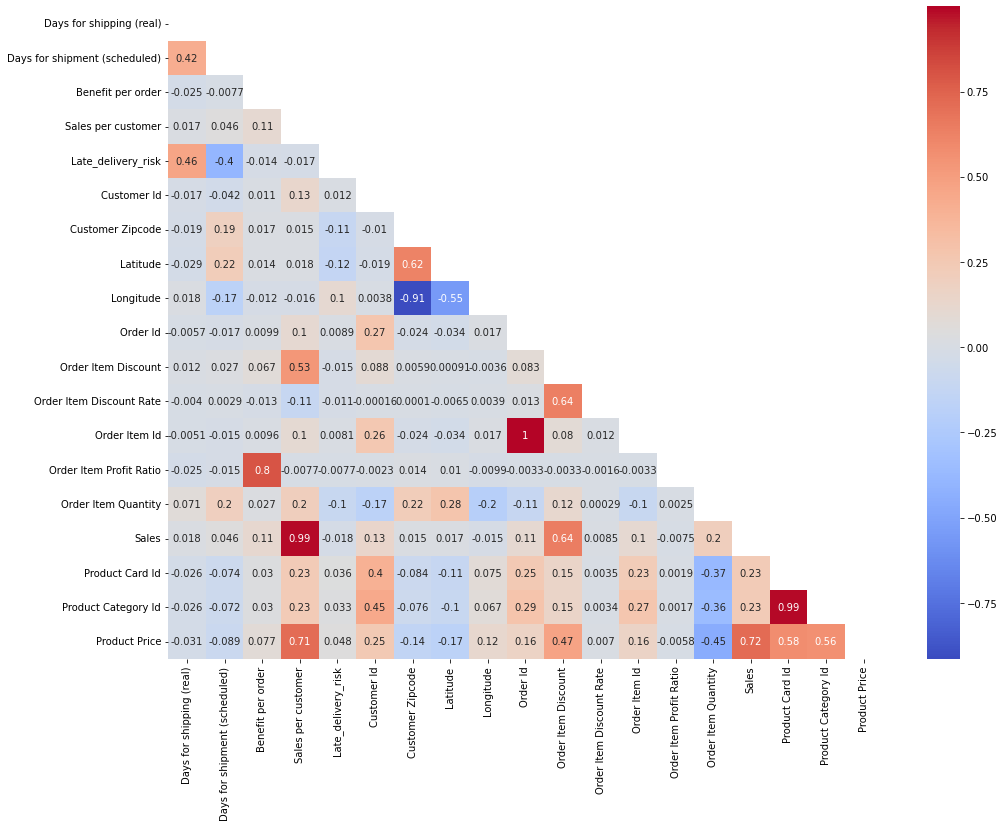

In [8]:
numerical_variables = [c for c in df.columns if df[c].dtypes != 'O']
fig, ax = plt.subplots(figsize = (16,12))
matrix = np.triu(df[numerical_variables].corr())
ax = sns.heatmap(df[numerical_variables].corr(), cmap='coolwarm', annot=True, mask=matrix)
plt.show()

## Money-related columns
- Sales = Product Price * Order Item Quantity
- Order Item Discount = Sales * Order Item Discount Rate (but 962 of them don't satisfy)
- Sales per customer = Sales - Order Item Discount (but 386 of them don't satisfy)

We can keep Sales, Order Item Quantity and Order Item Discount Rate for the classification.

In [9]:
print(sum(np.round(df['Product Price'] * df['Order Item Quantity'],2) != np.round(df['Sales'],2)))
print(sum(np.round(df['Sales']*df['Order Item Discount Rate'],2) != np.round(df['Order Item Discount'],2)))
print(sum(np.round(df['Sales per customer'],2) != np.round(df['Sales']-df['Order Item Discount'],2)))

0
968
386


## Further analysis (univariate analysis)
In this part, we focus on sales and late delivery risk. Using analysis methods like ABC analysis, we will find which categories (e.g. which products, which regions) have the highest contribution on sales. Then we will check late delivery rate of each category and try to find some points to optimize. 

In [9]:
#plot total number of orders and late delivery rate of each category
def plot_late_rate(col_name, figsize=(6,4)):
    df_temp = df.groupby(col_name)['Late_delivery_risk'].agg(['sum','count'], axis=1)
    df_temp['late rate'] = df_temp['sum'] / df_temp['count']
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x=df_temp.index, height=df_temp['count'], label='order number')
    ax2 = ax.twinx()
    ax2.plot(df_temp['late rate'], color='red', marker='*', label='late rate')
    ax.legend(loc='upper right', bbox_to_anchor=(1,1))
    ax2.legend(loc='upper right', bbox_to_anchor=(1,0.91))
    plt.show()

In [10]:
#plot total number of orders and late delivery rate of each category
def plot_sales_proportion(col_name, figsize=(6,4)):
    df_temp = df.groupby(col_name)['Sales'].agg(['sum','count'], axis=1)
    df_temp['sales proportion'] = df_temp['sum'] / sum(df_temp['sum'])
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x=df_temp.index, height=df_temp['count'], label='order number')
    ax2 = ax.twinx()
    ax2.plot(df_temp['sales proportion'], color='orange', marker='*', label='sales proportion')
    ax.legend(loc='upper right', bbox_to_anchor=(1,1))
    ax2.legend(loc='upper right', bbox_to_anchor=(1,0.91))
    plt.show()

### Overall Late Delivery Rate
Overall late delivery rate is 53%, which is pretty high!

In [11]:
df['Late_delivery_risk'].sum() / len(df)

0.5259720441921504

### Transaction Type
- 4 transaction types
- CASH and PAYMENT have higher late delivery rates and fewer orders

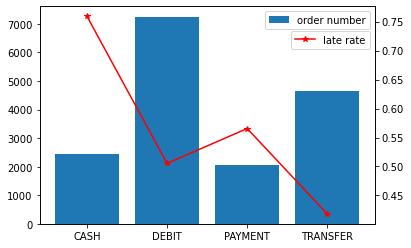

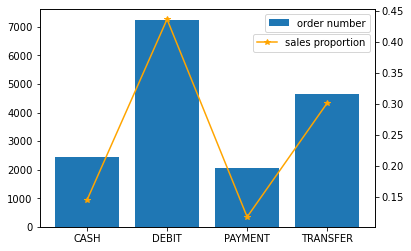

In [12]:
plot_late_rate('Type')
plot_sales_proportion('Type')

### Customer Country
- 2 customer countries (Country where the customer made the purchase)
    - EE. UU.: United States
    - Puerto Rico: a Caribbean island and unincorporated U.S. territory
- Puerto Rico has higher late delivery rate (because of the location)

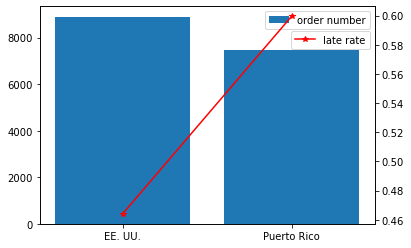

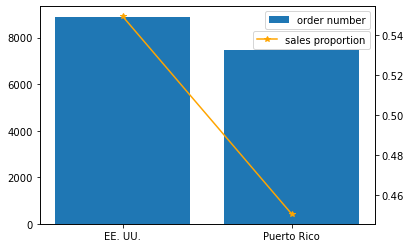

In [13]:
plot_late_rate('Customer Country')
plot_sales_proportion('Customer Country')

### Customer Segment
- 3 segments
- Consumer and Home Office have higher late delivery rate (maybe because the destinations varies a lot)

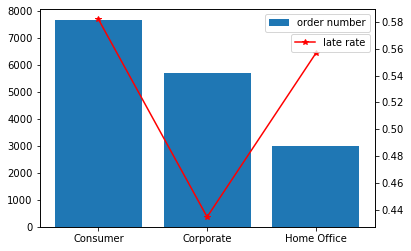

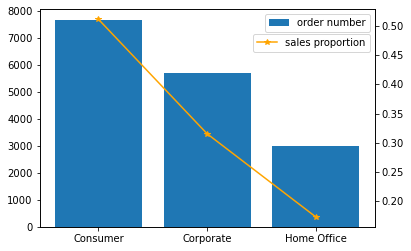

In [14]:
plot_late_rate('Customer Segment')
plot_sales_proportion('Customer Segment')

### Department Name
- 11 departments

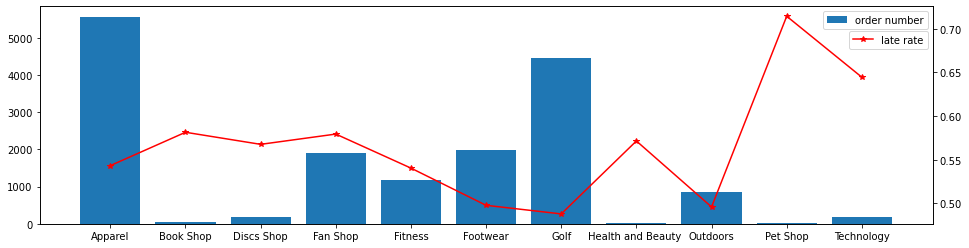

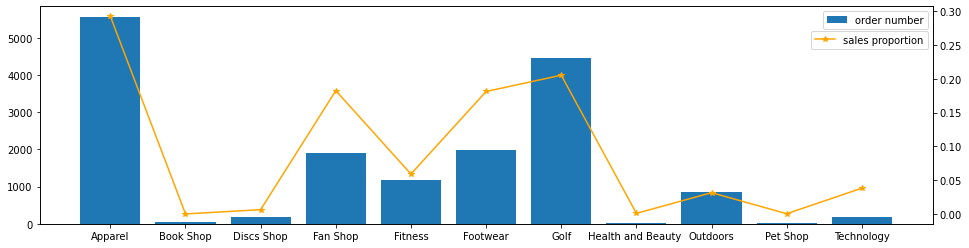

In [15]:
plot_late_rate('Department Name', figsize=(16,4))
plot_sales_proportion('Department Name', figsize=(16,4))

### Market
- Market to where the order is delivered: Africa, Europe, LATAM, Pacific Asia, USCA
- Europe has the highest late delivery rate with the highest order number and sales

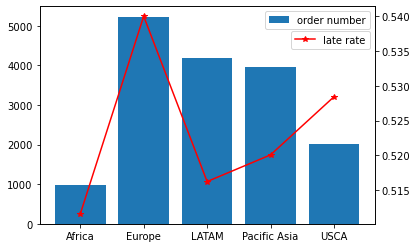

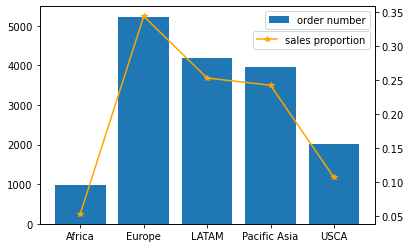

In [16]:
plot_late_rate('Market')
plot_sales_proportion('Market')

### Delivery Status / Order Status
Not sure about the meaning of Order Status

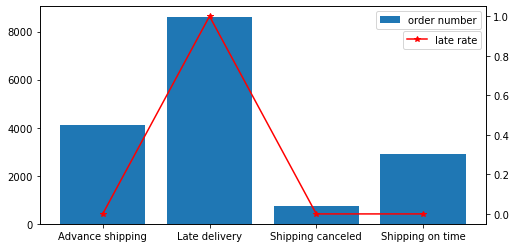

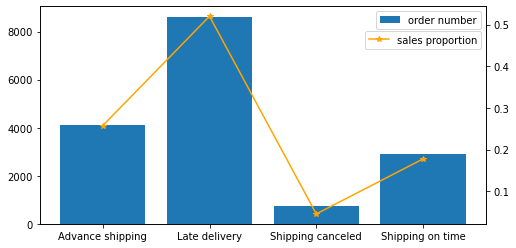

In [17]:
plot_late_rate('Delivery Status', figsize=(8,4))
plot_sales_proportion('Delivery Status', figsize=(8,4))

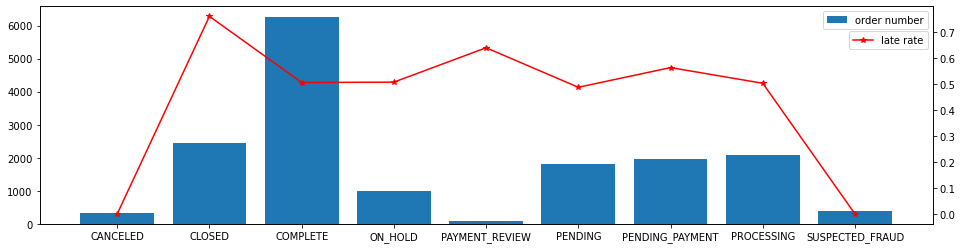

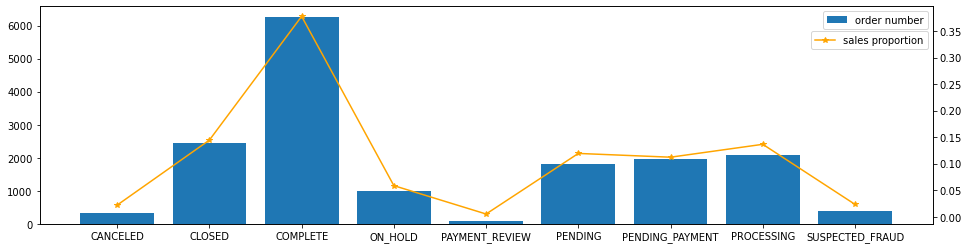

In [18]:
plot_late_rate('Order Status', figsize=(16,4))
plot_sales_proportion('Order Status', figsize=(16,4))

### Shipping Mode
- Standard Class has the lowest late delivery rate but highest order number and sales

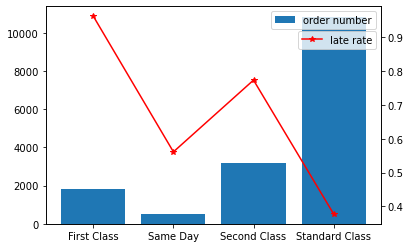

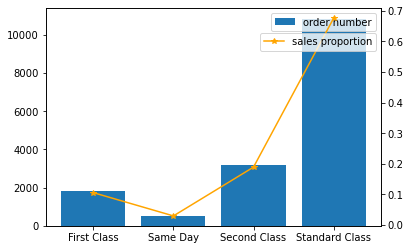

In [19]:
plot_late_rate('Shipping Mode')
plot_sales_proportion('Shipping Mode')

### Time series
- There is no obvious seasonality or trend pattern

In [20]:
df_t = df[['order date (DateOrders)', 'shipping date (DateOrders)', 'Late_delivery_risk', 'Sales']]
df_t['order date (DateOrders)'] = pd.to_datetime(df_t['order date (DateOrders)']).dt.to_period('M')
df_t['shipping date (DateOrders)'] = pd.to_datetime(df_t['shipping date (DateOrders)']).dt.to_period('M')
df_t.head()

,order date (DateOrders),shipping date (DateOrders),Late_delivery_risk,Sales
0,2018-01,2018-03,0,327.75
1,2018-01,2018-01,1,327.75
2,2018-01,2018-01,0,327.75
3,2018-01,2018-01,0,327.75
4,2018-01,2018-01,0,327.75


<AxesSubplot:xlabel='order date (DateOrders)'>

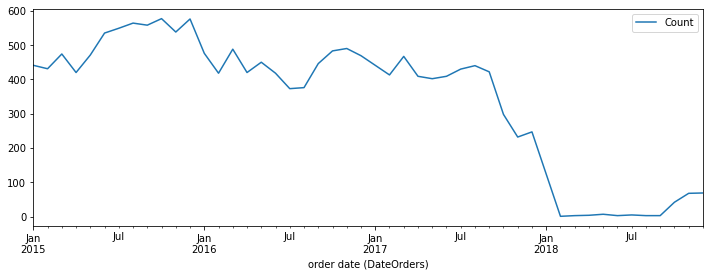

In [21]:
df_t.groupby('order date (DateOrders)').count().reset_index().plot(x='order date (DateOrders)', y='Sales', figsize=(12,4), label='Count')

<AxesSubplot:xlabel='order date (DateOrders)'>

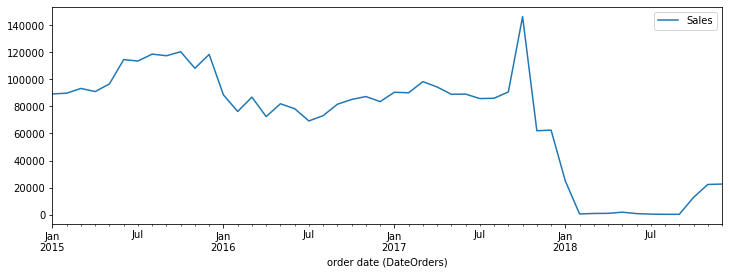

In [22]:
df_t.groupby('order date (DateOrders)').sum().reset_index().plot(x='order date (DateOrders)', y='Sales', figsize=(12,4))

<AxesSubplot:xlabel='order date (DateOrders)'>

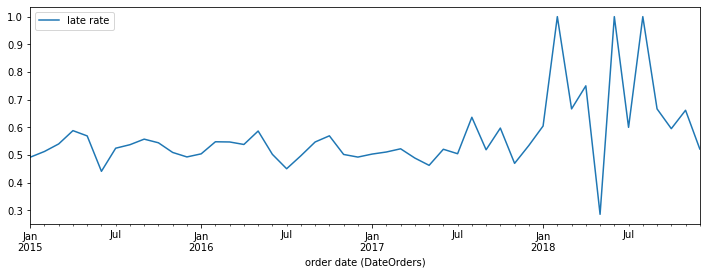

In [23]:
late_t = df_t.groupby('order date (DateOrders)')['Late_delivery_risk'].agg(['sum','count']).reset_index()
late_t['late rate'] = late_t['sum'] / late_t['count']
late_t.plot(x='order date (DateOrders)', y='late rate', figsize=(12,4))

### Geometric data
- Customer City / Country / Segment / State / Street / Zipcode
- Visualization is easier in Tableau

#### Originated Location (Latitude / Longitude)
the originated location of the order

In [24]:
# m = folium.Map(tiles="cartodbpositron")
# marker_cluster = MarkerCluster().add_to(m)
# #for each coordinate, create circlemarker of user percent
# for i in range(len(df)):
#     lat = df.iloc[i]['Latitude']
#     long = df.iloc[i]['Longitude']
#     radius=5
#     popup_text = """City: {}<br>
#                  Sales: {}<br>"""
#     popup_text = popup_text.format(df.iloc[i]['Customer City'],
#                                    df.iloc[i]['Sales'])
#     folium.CircleMarker(location=[lat, long], radius=radius, popup=popup_text, fill=True).add_to(marker_cluster)
# #show the map
# m

#### Order Destination
source: https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10

In [25]:
# country_sales = df.groupby('Order Country').sum()['Sales'].reset_index()
# translator = google_translator() #Spanish to English
# country_sales['Country Name'] = country_sales['Order Country'].apply(lambda x: translator.translate(x, lang_src='es', lang_tgt='en').strip())  

# #function to convert to alpah2 country codes and continents
# def get_country_continent(col):
#     try:
#         cn_a2_code =  country_name_to_country_alpha2(col)
#     except:
#         cn_a2_code = 'Unknown' 
#     try:
#         cn_continent = country_alpha2_to_continent_code(cn_a2_code)
#     except:
#         cn_continent = 'Unknown' 
#     return (cn_a2_code, cn_continent)

# country_sales['codes'] = country_sales['Country Name'].apply(lambda x: get_country_continent(x))
# country_sales['Country'] = country_sales['codes'].apply(lambda x: x[0])
# country_sales['Continent'] = country_sales['codes'].apply(lambda x: x[1])

In [26]:
# #deal with unknowns (correct the country names)
# unknowns = list(country_sales[country_sales['Country']=='Unknown']['Country Name'])
# correct_names = ['Azerbaijan','Bangladesh','Barbados','Bahrain','Benin','Bolivia','Burkina Faso','Cameroon','Chile','El Salvador',
#                  'Spain','Gabon','Guadeloupe','Iran','Japan','Myanmar','Oman','Pakistan','Panama','Papua New Guinea',
#                  'Paraguay','Peru','Democratic Republic of the Congo','Republic of the Congo','Sudan',"Switzerland",'Thailand','Tajikistan','Togo','Tunisia','Djibouti']
# country_sales['Country Name'].replace(unknowns, correct_names, inplace=True)

# country_sales['codes'] = country_sales['Country Name'].apply(lambda x: get_country_continent(x))
# country_sales['Country'] = country_sales['codes'].apply(lambda x: x[0])
# country_sales['Continent'] = country_sales['codes'].apply(lambda x: x[1])

In [27]:
# country_sales.head()

In [28]:
# #function to get longitude and latitude data from country code
# geolocator = Nominatim(user_agent="zg2376@columbia.edu")
# def geolocate(country):
#     try:
#         # Geolocate the center of the country
#         loc = geolocator.geocode(country)
#         # And return latitude and longitude
#         return (loc.latitude, loc.longitude)
#     except:
#         # Return missing value
#         return np.nan
    
# country_sales['geo'] = country_sales['Country Name'].apply(lambda x: geolocate(x))

In [29]:
# country_sales['geo_latitude'] = country_sales['geo'].apply(lambda x: x[0])
# country_sales['geo_longitude'] = country_sales['geo'].apply(lambda x: x[1])
# country_sales.head()

In [30]:
# #Create a world map to show distributions

# #empty map
# m = folium.Map(tiles="cartodbpositron")
# marker_cluster = MarkerCluster().add_to(m)
# #for each coordinate, create circlemarker of user percent
# for i in range(len(country_sales)):
#     lat = country_sales.iloc[i]['geo_latitude']
#     long = country_sales.iloc[i]['geo_longitude']
#     radius=10
#     popup_text = """Country: {}<br>
#                  Total Sales: {}<br>"""
#     popup_text = popup_text.format(country_sales.iloc[i]['Country Name'],
#                                    country_sales.iloc[i]['Sales'])
#     folium.CircleMarker(location=[lat, long], radius=radius, popup=popup_text, fill=True).add_to(marker_cluster)
# #show the map
# m

# Feature Engineering
We may think about the reasons for late delivery before prediction. There are some possible features we already have. 

- Originated customer features
    - Customer Country 2
    - Customer Segment 3
    - Transaction Type 4
- Shipping features
    - Market 5
    - Shipping Mode 4
- Product features
    - Department Name 11
    
There are still some other features that we can dig into
- Order distance (geocode) 1
- Product value (ABC analysis) 3
- Customer value (ABC analysis) 3
    - but this can't be applied to new customers

(Here we don't consider time series features for now since it doesn't have obvious seasonality.)

## Order Distance
### Get geocode
We already have the originated latitude and longitude, we need to get the geocode of the destination with Order City and Order Country.
- Country is needed since there are cities from different countries have the same city name.
- Get geocode (latitude, longitude) with geopy, https://colab.research.google.com/drive/1jnrmDgcM9YpQp3P0eKpiGDH8iXXFC1w7?usp=sharing, the result is saved in geocode.csv

In [31]:
geocode = pd.read_csv('geocode.csv', index_col=0)
df = pd.merge(df, geocode[['Order City', 'Order Country','geo']],  how='left', on=['Order City', 'Order Country'])
df['geo'] = df['geo'].apply(ast.literal_eval) #convert string to tuple
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Name,Customer City,Customer Country,Customer Id,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Name,Latitude,Longitude,Market,Order City,Order Country,order date (DateOrders),Order Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Profit Ratio,Order Item Quantity,Sales,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,shipping date (DateOrders),Shipping Mode,geo
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,20755,Consumer,PR,5365 Noble Nectar Island,725,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,1/31/2018 22:56,77202,13.110000,0.04,180517,0.29,1,327.75,Southeast Asia,Java Occidental,COMPLETE,1360,73,Smart watch,327.75,3/2/18 22:56,Standard Class,"(-6.2349858, 106.9945444)"
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,Sporting Goods,Caguas,Puerto Rico,19492,Consumer,PR,2679 Rustic Loop,725,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,1/13/2018 12:27,75939,16.389999,0.05,179254,-0.80,1,327.75,South Asia,Rajastán,PENDING,1360,73,Smart watch,327.75,1/18/2018 12:27,Standard Class,"(28.0159286, 73.3171367)"
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,Sporting Goods,San Jose,EE. UU.,19491,Consumer,CA,8510 Round Bear Gate,95125,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,1/13/2018 12:06,75938,18.030001,0.06,179253,-0.80,1,327.75,South Asia,Rajastán,CLOSED,1360,73,Smart watch,327.75,1/17/2018 12:06,Standard Class,"(28.0159286, 73.3171367)"
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,Sporting Goods,Los Angeles,EE. UU.,19490,Home Office,CA,3200 Amber Bend,90027,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,1/13/2018 11:45,75937,22.940001,0.07,179252,0.08,1,327.75,Oceania,Queensland,COMPLETE,1360,73,Smart watch,327.75,1/16/2018 11:45,Standard Class,"(-19.2569391, 146.8239537)"
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,19489,Corporate,PR,8671 Iron Anchor Corners,725,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,1/13/2018 11:24,75936,29.500000,0.09,179251,0.45,1,327.75,Oceania,Queensland,PENDING_PAYMENT,1360,73,Smart watch,327.75,1/15/2018 11:24,Standard Class,"(-19.2569391, 146.8239537)"


### Calculate distance
- There may be a mistake since actually the originated location may not be the place that the order is sent from. 
- The correlation coefficient between Late_delivery_risk and distance is pretty low :(

In [32]:
def get_distance(start, end): #start and end are tuples
    return distance.distance(start, end).miles #from geopy import distance
    
df['distance'] = df.apply(lambda x: get_distance((x['Latitude'], x['Longitude']), x['geo']), axis=1)

In [33]:
print(df[['Late_delivery_risk', 'distance']].corr())

longdis = df[df['distance']>10000]
shortdis = df[df['distance']<=10000]

print(len(longdis), longdis['Late_delivery_risk'].sum(), longdis['Late_delivery_risk'].sum() / len(longdis))
print(len(shortdis), shortdis['Late_delivery_risk'].sum(), shortdis['Late_delivery_risk'].sum() / len(shortdis))

                    Late_delivery_risk  distance
Late_delivery_risk            1.000000  0.007724
distance                      0.007724  1.000000
700 416 0.5942857142857143
15683 8201 0.5229229101574954


## Train Test Split
We must do train test split before other processing (one-hot encoding, standardization, add new features using population statistics) to avoid adding bias.

In [34]:
m_df = df[['Late_delivery_risk', 'Type', 'Customer Country', 'Customer Segment', 'Department Name', 'Market', 
           'Shipping Mode', 'Sales', 'Order Item Quantity', 'Order Item Discount Rate', 'distance', 
           'Product Name']]

In [35]:
y = m_df['Late_delivery_risk']
X = m_df.drop('Late_delivery_risk', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## ABC Analysis
- Performing ABC analysis to discover which Products, Customers (Regions, Days, State and Hours) contribute to 80% of the sales

In [36]:
total_sales = X_train['Sales'].sum()

def ABC_category(value):
    if value > 0 and value < 0.8*total_sales:
        return 'A'
    elif value >= 0.8*total_sales and value < 0.95*total_sales:
        return 'B'
    else:
        return 'C'

In [37]:
product_df = X_train[['Product Name','Sales']].groupby(['Product Name']).sum().sort_values('Sales', ascending=False).reset_index()
product_df['CUMULATIVE'] = product_df['Sales'].cumsum(axis=0)
product_df['productABC'] = product_df['CUMULATIVE'].apply(ABC_category)
print(product_df['productABC'].value_counts())

# customer_df = X_train[['Customer Id','Sales']].groupby(['Customer Id']).sum().sort_values('Sales', ascending =False).reset_index()
# customer_df['CUMULATIVE'] = customer_df['Sales'].cumsum(axis=0)
# customer_df['customerABC'] = customer_df['CUMULATIVE'].apply(ABC_category)
# print(customer_df['customerABC'].value_counts())

C    63
B    21
A     6
Name: productABC, dtype: int64


In [38]:
X_train = pd.merge(X_train, product_df[['Product Name', 'productABC']],  how='left', on='Product Name')
X_test = pd.merge(X_test, product_df[['Product Name', 'productABC']],  how='left', on='Product Name')

X_train = X_train.drop('Product Name', axis=1)
X_test = X_test.drop('Product Name', axis=1)
# X_train = pd.merge(X_train, customer_df[['Customer Id', 'customerABC']],  how='left', on='Customer Id')
# X_test = pd.merge(X_test, customer_df[['Customer Id', 'customerABC']],  how='left', on='Customer Id')

# X_train = X_train.drop(['Product Name', 'Customer Id'], axis=1)
# X_test = X_test.drop(['Product Name', 'Customer Id'], axis=1)

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13106 entries, 0 to 13105
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Type                      13106 non-null  object 
 1   Customer Country          13106 non-null  object 
 2   Customer Segment          13106 non-null  object 
 3   Department Name           13106 non-null  object 
 4   Market                    13106 non-null  object 
 5   Shipping Mode             13106 non-null  object 
 6   Sales                     13106 non-null  float64
 7   Order Item Quantity       13106 non-null  int64  
 8   Order Item Discount Rate  13106 non-null  float64
 9   distance                  13106 non-null  float64
 10  productABC                13106 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 1.2+ MB


In [40]:
# fig, ax = plt.subplots(figsize = (10,7))
# df2['CATEGORY'].value_counts().plot.pie(autopct='%.2f',title='% CUSTOMERS IN EACH CATEGORY')
# fig.set_facecolor('lightgrey')
# plt.show()

## One-hot Encoding and Standardization
- Response: 'Late_delivery_risk'
- One-hot: ['Type', 'Customer Country', 'Customer Segment', 'Department Name', 'Market', 'Shipping Mode', 'productABC', 'customerABC']
- Standardization: ['Sales', 'Order Item Quantity', 'Order Item Discount Rate', 'distance']

- Drop: ['Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Delivery Status', 'Category Name', 'Customer City', 'Customer Id', 'Customer State', 'Customer Street', 'Customer Zipcode', 'Latitude', 'Longitude', 'Order City', 'Order Country', 'order date (DateOrders)', 'Order Id', 'Order Item Discount', 'Order Item Id', 'Order Item Profit Ratio', 'Order Region', 'Order State', 'Order Status', 'Product Card Id', 'Product Category Id', 'Product Name', 'Product Price', 'shipping date (DateOrders)', 'geo']
       

In [41]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [42]:
scaler = StandardScaler().fit(X_train[['Sales', 'Order Item Quantity', 'Order Item Discount Rate', 'distance']])
X_train[['Sales', 'Order Item Quantity', 'Order Item Discount Rate', 'distance']] = scaler.transform(X_train[['Sales', 'Order Item Quantity', 'Order Item Discount Rate', 'distance']])
X_test[['Sales', 'Order Item Quantity', 'Order Item Discount Rate', 'distance']] = scaler.transform(X_test[['Sales', 'Order Item Quantity', 'Order Item Discount Rate', 'distance']])

In [43]:
X_train.head()

,Sales,Order Item Quantity,Order Item Discount Rate,distance,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Customer Country_Puerto Rico,Customer Segment_Corporate,Customer Segment_Home Office,Department Name_Book Shop,Department Name_Discs Shop,Department Name_Fan Shop,Department Name_Fitness,Department Name_Footwear,Department Name_Golf,Department Name_Health and Beauty,Department Name_Outdoors,Department Name_Pet Shop,Department Name_Technology,Market_Europe,Market_LATAM,Market_Pacific Asia,Market_USCA,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,productABC_B,productABC_C
0,0.655078,-1.017124,0.252433,-0.926304,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,-0.054837,0.870593,-1.305255,-0.145005,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0.654865,1.499832,1.385297,0.719300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,-0.623025,-0.387885,-1.163647,-1.290254,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,-0.764965,-1.017124,-1.022039,-1.204232,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [44]:
X_test.head()

,Sales,Order Item Quantity,Order Item Discount Rate,distance,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Customer Country_Puerto Rico,Customer Segment_Corporate,Customer Segment_Home Office,Department Name_Book Shop,Department Name_Discs Shop,Department Name_Fan Shop,Department Name_Fitness,Department Name_Footwear,Department Name_Golf,Department Name_Health and Beauty,Department Name_Outdoors,Department Name_Pet Shop,Department Name_Technology,Market_Europe,Market_LATAM,Market_Pacific Asia,Market_USCA,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,productABC_B,productABC_C
0,-0.942408,0.241354,2.093337,-1.035582,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1
1,-0.551948,-1.017124,1.102081,-0.216960,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,-1.055449,-1.017124,0.677257,0.031939,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
3,-0.623096,0.241354,-1.305255,0.344414,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0
4,-0.693888,1.499832,-1.305255,-0.912228,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


# Classification Models
- predict late delivery risk
- here we use threshold = 0.5 by default

## Dummy Classifier
- If we classify each sample as 1, the accuracy is 0.533, so our models should at least be better than this.

In [45]:
print(y_test.sum(), len(y_test), y_test.sum()/len(y_test))

1747 3277 0.5331095514189808


## Linear Regression

In [46]:
clf1 = sm.OLS(y_train, X_train).fit()
clf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Late_delivery_risk   R-squared (uncentered):                   0.563
Model:                            OLS   Adj. R-squared (uncentered):              0.562
Method:                 Least Squares   F-statistic:                              581.6
Date:                Thu, 21 Apr 2022   Prob (F-statistic):                        0.00
Time:                        20:29:48   Log-Likelihood:                         -8935.0
No. Observations:               13106   AIC:                                  1.793e+04
Df Residuals:                   13077   BIC:                                  1.814e+04
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Sales                                 -0.0187      0.007     -2.866      0.004      -0.032      -0.006
Order Item Quantity                   -0.0015      0.006     -0.251      0.802      -0.013       0.010
Order Item Discount Rate              -0.0043      0.004     -1.035      0.301      -0.013       0.004
distance                               0.1033      0.009     11.255      0.000       0.085       0.121
Type_DEBIT                             0.1540      0.015     10.502      0.000       0.125       0.183
Type_PAYMENT                           0.2522      0.022     11.544      0.000       0.209       0.295
Type_TRANSFER                          0.1055      0.016      6.516      0.000       0.074       0.137
Customer Country_Puerto Rico           0.1005      0.011      8.836      0.000       0.078       0.123
Customer Segment_Corporate             0.0584      0.011      5.510      0.000       0.038       0.079
Customer Segment_Home Office          -0.0660      0.017     -3.882      0.000      -0.099      -0.033
Department Name_Book Shop              0.0161      0.084      0.192      0.848      -0.148       0.181
Department Name_Discs Shop             0.0222      0.042      0.529      0.597      -0.060       0.105
Department Name_Fan Shop               0.1007      0.017      5.815      0.000       0.067       0.135
Department Name_Fitness                0.0579      0.022      2.629      0.009       0.015       0.101
Department Name_Footwear               0.0892      0.016      5.755      0.000       0.059       0.120
Department Name_Golf                   0.0599      0.012      4.798      0.000       0.035       0.084
Department Name_Health and Beauty     -0.0467      0.141     -0.331      0.740      -0.323       0.229
Department Name_Outdoors               0.0590      0.026      2.273      0.023       0.008       0.110
Department Name_Pet Shop               0.0698      0.119      0.588      0.556      -0.163       0.302
Department Name_Technology             0.1619      0.053      3.074      0.002       0.059       0.265
Market_Europe                          0.5633      0.014     39.733      0.000       0.536       0.591
Market_LATAM                           0.6375      0.018     36.030      0.000       0.603       0.672
Market_Pacific Asia                    0.4048      0.018     22.530      0.000       0.370       0.440
Market_USCA                            0.6687      0.021     31.585      0.000       0.627       0.710
Shipping Mode_Same Day                -0.1085      0.026     -4.221      0.000      -0.159      -0.058
Shipping Mode_Second Class            -0.0143      0.017     -0.827      0.408      -0.048       0.0

In [47]:
#default threshold 0.5
clf1_pred = clf1.predict(X_test).apply(lambda x: 1 if x >= 0.5 else 0)
print(confusion_matrix(y_test, clf1_pred))
print(classification_report(y_test, clf1_pred))

[[1177  353]
 [ 766  981]]
              precision    recall  f1-score   support

           0       0.61      0.77      0.68      1530
           1       0.74      0.56      0.64      1747

    accuracy                           0.66      3277
   macro avg       0.67      0.67      0.66      3277
weighted avg       0.67      0.66      0.66      3277



## Ridge and Lasso

In [48]:
params = [{"alpha": np.logspace(-4, 4, 100)}]
clf2 = GridSearchCV(Ridge(), params, cv=10, refit=True).fit(X_train, y_train)
clf2_pred = pd.Series(clf2.predict(X_test)).apply(lambda x: 1 if x >= 0.5 else 0)
print(confusion_matrix(y_test, clf2_pred))
print(classification_report(y_test, clf2_pred))

[[1340  190]
 [ 830  917]]
              precision    recall  f1-score   support

           0       0.62      0.88      0.72      1530
           1       0.83      0.52      0.64      1747

    accuracy                           0.69      3277
   macro avg       0.72      0.70      0.68      3277
weighted avg       0.73      0.69      0.68      3277



In [49]:
params = [{"alpha": np.logspace(-4, 4, 100)}]
clf2 = GridSearchCV(Ridge(), params, cv=10, refit=True).fit(X_train, y_train)
clf2_pred = pd.Series(clf2.predict(X_test)).apply(lambda x: 1 if x >= 0.5 else 0)
print(confusion_matrix(y_test, clf2_pred))
print(classification_report(y_test, clf2_pred))
print(clf2.best_estimator_)

[[1340  190]
 [ 830  917]]
              precision    recall  f1-score   support

           0       0.62      0.88      0.72      1530
           1       0.83      0.52      0.64      1747

    accuracy                           0.69      3277
   macro avg       0.72      0.70      0.68      3277
weighted avg       0.73      0.69      0.68      3277

Ridge(alpha=12.328467394420684)


In [50]:
params = [{"alpha": np.logspace(-4, 4, 100)}]
clf3 = GridSearchCV(Lasso(), params, cv=10, refit=True).fit(X_train, y_train)
clf3_pred = pd.Series(clf3.predict(X_test)).apply(lambda x: 1 if x >= 0.5 else 0)
print(confusion_matrix(y_test, clf3_pred))
print(classification_report(y_test, clf3_pred))
print(clf3.best_estimator_)

[[1331  199]
 [ 822  925]]
              precision    recall  f1-score   support

           0       0.62      0.87      0.72      1530
           1       0.82      0.53      0.64      1747

    accuracy                           0.69      3277
   macro avg       0.72      0.70      0.68      3277
weighted avg       0.73      0.69      0.68      3277

Lasso(alpha=0.000774263682681127)


In [51]:
#Non-zero and coefficients
print('non-zero coefficients: ')
print(X_train.columns[clf3.best_estimator_.coef_!=0])

print('zero coefficients: ')
print(X_train.columns[clf3.best_estimator_.coef_==0])

non-zero coefficients: 
Index(['Order Item Quantity', 'Order Item Discount Rate', 'distance',
       'Type_DEBIT', 'Type_PAYMENT', 'Type_TRANSFER',
       'Customer Segment_Corporate', 'Customer Segment_Home Office',
       'Department Name_Fan Shop', 'Department Name_Golf', 'Market_Europe',
       'Market_LATAM', 'Market_Pacific Asia', 'Shipping Mode_Same Day',
       'Shipping Mode_Second Class', 'Shipping Mode_Standard Class'],
      dtype='object')
zero coefficients: 
Index(['Sales', 'Customer Country_Puerto Rico', 'Department Name_Book Shop',
       'Department Name_Discs Shop', 'Department Name_Fitness',
       'Department Name_Footwear', 'Department Name_Health and Beauty ',
       'Department Name_Outdoors', 'Department Name_Pet Shop',
       'Department Name_Technology', 'Market_USCA', 'productABC_B',
       'productABC_C'],
      dtype='object')


## Logistic Regression

In [52]:
clf4 = LogisticRegression(penalty='none').fit(X_train, y_train)
clf4_pred = clf4.predict(X_test)
print(confusion_matrix(y_test, clf4_pred))
print(classification_report(y_test, clf4_pred))

[[1330  200]
 [ 829  918]]
              precision    recall  f1-score   support

           0       0.62      0.87      0.72      1530
           1       0.82      0.53      0.64      1747

    accuracy                           0.69      3277
   macro avg       0.72      0.70      0.68      3277
weighted avg       0.73      0.69      0.68      3277



## Random Forest

In [54]:
# params = { 
#     'n_estimators': [100, 300, 500],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' : ['gini', 'entropy']
# }
# clf5 = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=10, refit=True).fit(X_train, y_train)

In [55]:
# clf5_pred = clf5.predict(X_test)
# print(confusion_matrix(y_test, clf5_pred))
# print(classification_report(y_test, clf5_pred))
# print(clf5.best_estimator_)

## KNN

In [56]:
# params = [{"n_neighbors": np.arange(3, 51)}]
# clf6 = GridSearchCV(KNeighborsClassifier(), params, cv=10, refit=True).fit(X_train, y_train)
# clf6_pred = pd.Series(clf6.predict(X_test)).apply(lambda x: 1 if x >= 0.5 else 0)
# print(confusion_matrix(y_test, clf6_pred))
# print(classification_report(y_test, clf6_pred))
# print(clf6.best_estimator_)

## XGBoost

In [136]:
clf7 = xgb.XGBClassifier(objective="binary:logistic", eval_metric='mlogloss').fit(X_train, y_train)
clf7_pred = pd.Series(clf7.predict_proba(X_test)[:,1]).apply(lambda x: 1 if x >= 0.5 else 0)
print(confusion_matrix(y_test, clf7_pred))
print(classification_report(y_test, clf7_pred))

# params = {
#     "max_depth": [3, 4, 5, 7],
#     "learning_rate": [0.1, 0.01, 0.05],
#     "gamma": [0, 0.25, 1],
#     "reg_lambda": [0, 1, 10],
#     "scale_pos_weight": [1, 3, 5],
#     "subsample": [0.8],
#     "colsample_bytree": [0.5],
# }
# clf7 = GridSearchCV(xgb.XGBClassifier(objective="binary:logistic", eval_metric='mlogloss'), params, cv=10, refit=True).fit(X_train, y_train)
# clf7_pred = pd.Series(clf7.predict(X_test)).apply(lambda x: 1 if x >= 0.5 else 0)
# print(confusion_matrix(y_test, clf7_pred))
# print(classification_report(y_test, clf7_pred))
# print(clf7.best_estimator_)

[[1183  347]
 [ 618 1129]]
              precision    recall  f1-score   support

           0       0.66      0.77      0.71      1530
           1       0.76      0.65      0.70      1747

    accuracy                           0.71      3277
   macro avg       0.71      0.71      0.71      3277
weighted avg       0.71      0.71      0.71      3277



# Find Optimal Threshold
Now we try to combine machine learning and optimization together. 

**optimize the decision threshold** (similar to Tahoe Healthcare case study)

Suppose each late delivery has a loss (l). Suppose we can take some actions with a cost (c) to reduce the probability of late delivery.

We can make some assumptions on the values of l and c:
- l: The value can depend on customer retention
    - according to https://clutch.co/logistics/resources/how-two-day-delivery-impacts-small-businesses, 45% of the customers say they are unlikely to continue ordering from a company if it delivers a package late
    - l = 0.45 * Benefit per order
- c: The value can depend on the specific actions we take.
    - Maybe expend the scheduled delivery time. This will reduce the competitiveness compared to competitors.

Now we wonder when we should take the actions to prevent an order from being late. 
1. predict late probability (p) of orders
2. set a threshold (r)
    - if $p \ge r$ => orders predicted late => take actions
    - if $p<r$ => orders predicted on time => do nothing

expected costs:
- tp = c+0.1*l: late actually, late predicted
- tn = 0: on time actually, on time predicted
- fp = c: on time actually, late predicted
- fn = l: late actually, on time predicted

## Lasso

optimal threshold: 0.67
lowest cost: 1473500.0


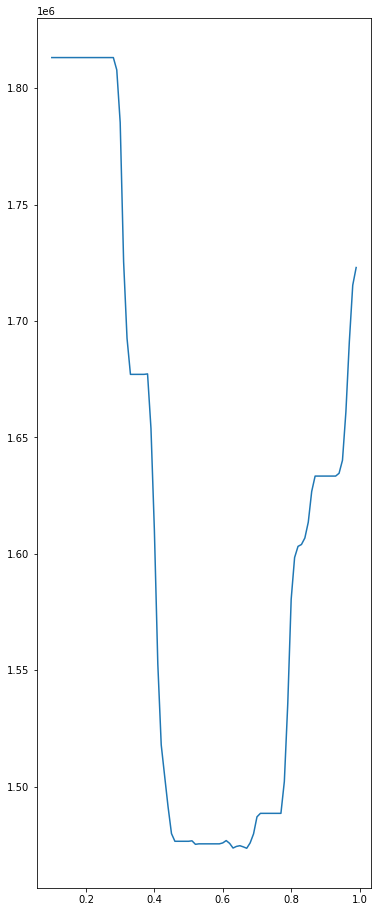

In [117]:
c = 500
l = 1000
p = 0.1

ctp = c + p*l
ctn = 0
cfp = c
cfn = l

thresholds = np.arange(1, 10, 0.1) / 10
costs = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    y_pred = pd.Series(clf3.predict(X_test)).apply(lambda x: 1 if x >= thresholds[i] else 0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    costs[i] = tn*ctn + fp*cfp + fn*cfn + tp*ctp
    
plt.figure(figsize=(6,16))
plt.plot(thresholds, costs)
print("optimal threshold: {:.2f}".format(thresholds[np.argmin(costs)]))
print("lowest cost: {}".format(min(costs)))

In [105]:
# results = np.zeros((len(thresholds), 3))
# for i in range(len(thresholds)):
# #     print(i)
#     y_pred = pd.Series(clf3.predict(X_test)).apply(lambda x: 1 if x >= thresholds[i] else 0)
#     accu = accuracy_score(y_test, y_pred)
#     reca = recall_score(y_test, y_pred)
#     preci = precision_score(y_test, y_pred)
#     results[i-1] = np.array([accu, reca, preci])

In [118]:
# plt.plot(results)
# plt.legend(['accuracy','recall','precision'])

## XGBoost

optimal threshold: 0.62
lowest cost: 1454300.0


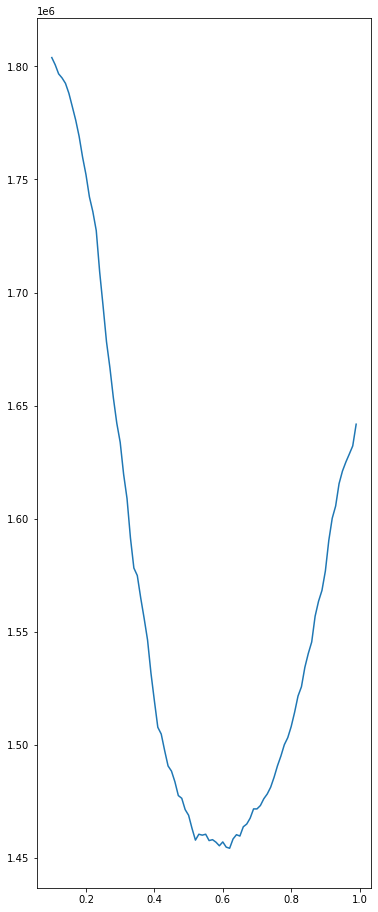

In [137]:
c = 500
l = 1000
p = 0.1

ctp = c + p*l
ctn = 0
cfp = c
cfn = l

thresholds = np.arange(1, 10, 0.1) / 10
costs = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    y_pred = pd.Series(clf7.predict_proba(X_test)[:,1]).apply(lambda x: 1 if x >= thresholds[i] else 0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    costs[i] = tn*ctn + fp*cfp + fn*cfn + tp*ctp
    
plt.figure(figsize=(6,16))
plt.plot(thresholds, costs)
print("optimal threshold: {:.2f}".format(thresholds[np.argmin(costs)]))
print("lowest cost: {}".format(min(costs)))